# Model 2

This notebook simulates population age distributions using model 2 (where agents survive according to an age-specific surivival probability -as in model 1- only if they are active. The activation probabilities are exogenous.). Model 2 may be suitable for age distributions where the fraction of the population within an age group does not decrease monotonically with age.

## Import packages

In [1]:
#Load in required libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os, warnings
from joblib import Parallel, delayed

warnings.simplefilter("ignore")

## Define necesssary functions

In [2]:
def pop_refine(pop_member): # Adjust surivival probabilities which are not valid for model 2
        
        parm_vectors = analytic_solver(pop_member)
        activation_rates, survive_probas = parm_vectors
        
        fix_attempt = 0
        
        # Pick survival probabilties
        while any(x > 1 for x in survive_probas):
            pop_member = np.random.rand(dimensions)*(1-baseval) + baseval
            pop_member[-1] = np.random.rand() #baseval argument is only to pick activation rates to return valid survival probabilties, final entry is p_n (survival probability of oldest age class) and so can just be chosen randomly

            parm_vectors = analytic_solver(pop_member)
            activation_rates, survive_probas = parm_vectors
            
            fix_attempt += 1
            
            if fix_attempt == 1e3:
                 break # if too many failed attempts to set the parameters (s.t. survival probabilty values don't exceed 1) have been made move on

        return pop_member


def analytic_solver(solution): # Calculate surivival probabilities for given target_dist and p_n
    
    activation_rates = solution[0:n_groups]
    survive_probas = np.zeros(n_groups)
    
    for group in range(n_groups-2):
        survive_probas[group] = (activation_rates[group+1]*target_dist[group+1])/(activation_rates[group]*target_dist[group])
        
    survive_probas[(n_groups-1)-1] = (1-solution[n_groups])*((activation_rates[(n_groups-1)]*target_dist[(n_groups-1)])/(activation_rates[(n_groups-1)-1]*target_dist[(n_groups-1)-1]))
    
    survive_probas[-1]=solution[n_groups]
    
    parm_vectors = (activation_rates, survive_probas)
    
    return parm_vectors


def obj_func(solution): # Run simulation
    
    parm_vectors = analytic_solver(solution)
    activation_rates, survive_probas = parm_vectors
    
    if all(x <1 for x in survive_probas):
    
        ages = np.random.randint(0, n_groups, size=pop_size).astype(int)
        ages_history = np.zeros((n_groups, max_itera))
        
        for itera in range(max_itera):
            
            active = activation_rates[ages] > np.random.rand(pop_size)
            trials = np.random.rand(pop_size)
            survival_probabilities = survive_probas[ages]
            survivals = trials <= survival_probabilities
            deaths = trials > survival_probabilities
            ages[active & survivals] += 1
            ages[ages==n_groups] -= 1
            ages[active & deaths] = 0
            
            uages, freqs = np.unique(ages, return_counts=True)
            ages_history[uages, itera] = freqs
            
            if itera == max_itera-1:

                plt.figure(0, figsize=(6,4))

                for i in range(n_groups):
                    plt.plot(ages_history[i,:], color = palette[i])
                plt.xlabel("Timestep")
                plt.ylabel("# of individuals in age group")
                plt.xlim([0,max_itera-1])
                plt.title(f"Population: {df.iloc[numselect,3]}")

                plt.tight_layout()
                plt.savefig(f'{home}data/results/timeseries_{df.iloc[numselect,3]}_model2.png', bbox_inches="tight", dpi=500)
                plt.show()
    
        ages_final = ages_history[:,-100::].mean(axis=1)
        ages_dist_noncum = ages_final/ages_final.sum()
        
        result = np.mean(np.abs(ages_dist_noncum - target_dist_noncum))
    
    else:
        result = 1000
        ages_dist_noncum = np.zeros(n_groups)

    return (result, ages_dist_noncum)


## Read in necessary data

In [3]:
# Set working directory
home =  os.getcwd()[:-4]

# Read in age distributions that are not monotic decreasing (md), as model 2 may be appropriate for these
df = pd.read_csv(f'{home}data/required/agedists_countries2019_other.csv')

## Set simulation parameters

In [4]:
pop_size = 10000 # Set number of agents within a simulation
max_itera = 350 # Set total number of timesteps in simulation

# Select age distribution to simulate
numselect=7 # Select index of the age distribution you want to simulate (numselect=7 returns Equatorial Guinea's age distribution)
target_dist_full = df.iloc[numselect, -22:-1]
target_dist = target_dist_full[target_dist_full>0].copy() #Drop all age classes containing zero individuals (can be absorbed into a neighbouring class)
n_groups = len(target_dist) # Set number of groups to match the number of age classes in the data
target_dist_noncum = target_dist/target_dist.sum() # Calculate age distribution from counts of individuals in eage age class
target_dist_cum = np.cumsum(target_dist/target_dist.sum()) # Calcualte cumulative age distribution from counts of individuals in each age class

# generate colour palette for timeseries plot based on n_groups
palette = sns.color_palette("flare", n_groups)

## Set calibration algorithm parameters

In [5]:
best_fitness = 1000
popsize = 100
mut=0.8
crossp=0.7
parallel_processes = -1 #use all available CPUs
algthresh = 1e-4 # Set the threshold for stoppping the calibration algorithm
maxsteps = 250 # Maximum number of steps to run of the calibration algorithm

# Generate an initial trial set of parameter values
bounds = np.array(list(zip(1e-6+np.zeros(n_groups + 1), np.ones(n_groups + 1))))
min_b, max_b = np.asarray(bounds).T
diff = np.fabs(min_b - max_b)
dimensions = len(bounds)
baseval = 0.4 #Minimum value for the initial parameter values
pop_init = np.random.rand(popsize, dimensions)*(1-baseval) + baseval
pop_init[:,-1] = np.random.rand(popsize) #baseval argument is only to pick activation rates to return valid survival probabilties, final entry is p_n (survival probability of oldest age class) and so can just be chosen randomly

# Correct any of the initial trial values which do not satisfy the requirements for model 2
pop = np.array(Parallel(n_jobs=parallel_processes, verbose=0)(delayed(pop_refine)(pop_member) for pop_member in pop_init))

# Create empty list to store "best" sets of calibrated parameters
best_sols = []

# Define plotting parameters
cap = [ "A", "B", "C"]

subcap_x = -0.05
subcap_y = 1.05

dpi_val = 100

## Run calibration algorithm

Mean absolute error: 0.0001336709244247908


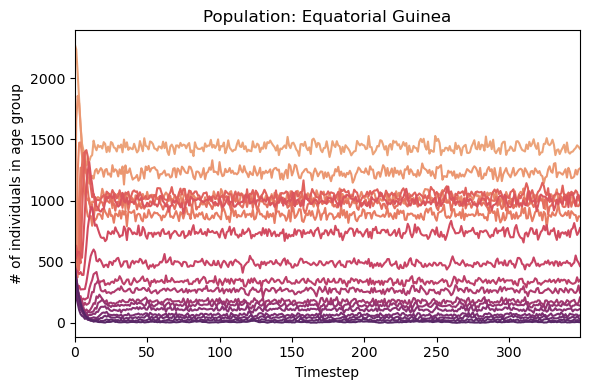

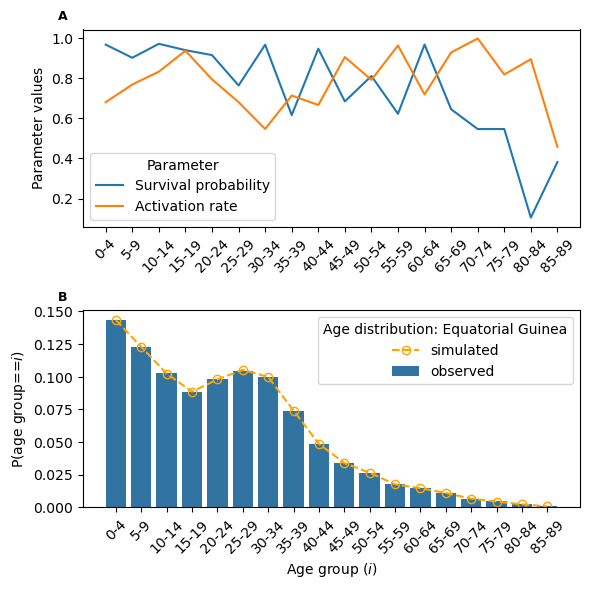

Mean absolute error: 0.00010364955375419321


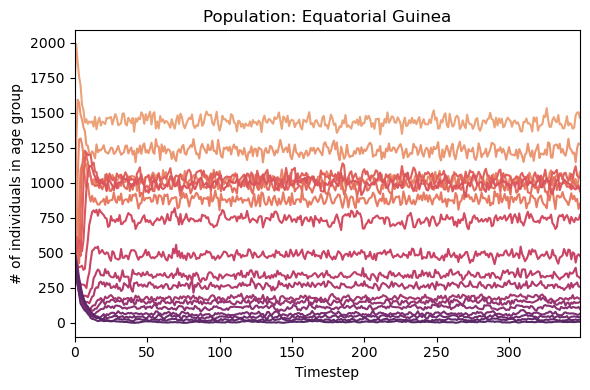

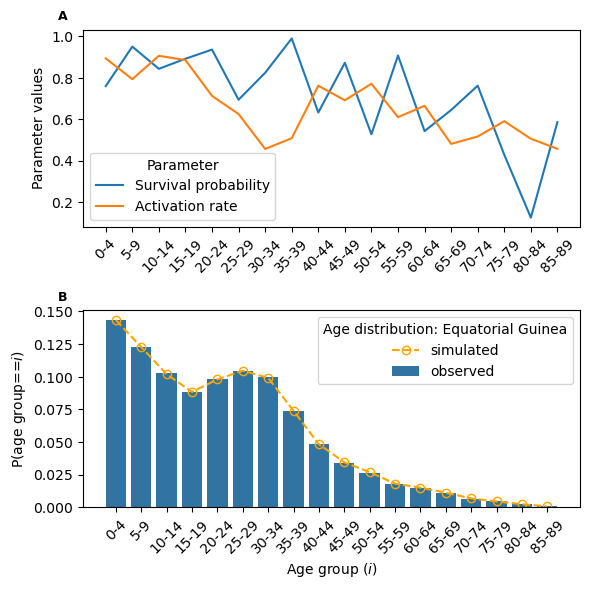

Mean absolute error: 8.495603045934455e-05


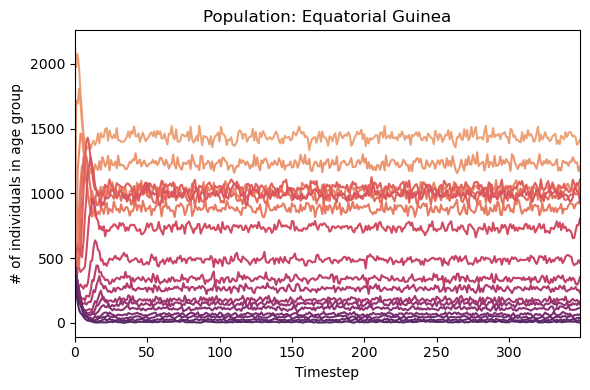

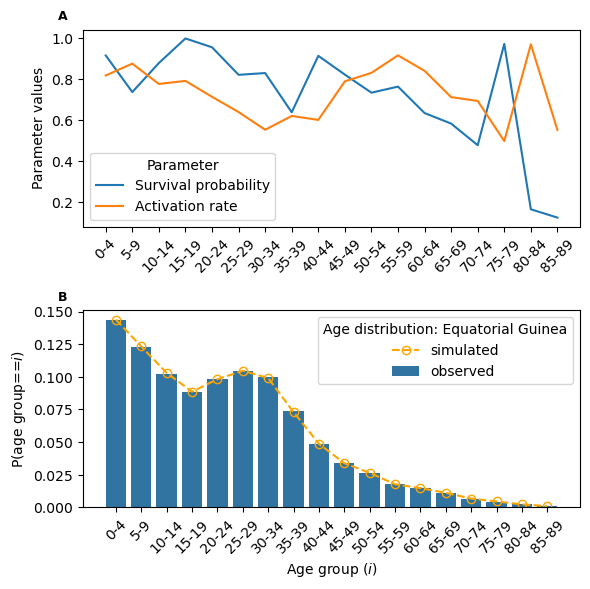

Desired accuracy has been achieved, ending fitting.
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figure(600x400)
Figu

In [6]:
    step = 0
    figcapture=0
    while step < maxsteps:
        
        output = Parallel(n_jobs=parallel_processes, verbose=0)(delayed(obj_func)(sol) for sol in pop) # Parallel
        fitness = [x[0] for x in output]
        best_idx = np.argmin(fitness)
        
        if fitness[best_idx] < best_fitness:
            best_sol = pop[best_idx]
            
            parm_vectors = analytic_solver(best_sol)
            activation_rates, survive_probas = parm_vectors
            
            best_fitness = fitness[best_idx]
            best_sols.append(best_sol)
            print(f'Mean absolute error: {best_fitness}')  
            
            numerical_dist_noncum = obj_func(best_sol)[1]

            # Generate plots of calibrated surivival and activation rates and resulting fit to the observed age distribution
            plt.figure(0, figsize=(600/dpi_val, 600/dpi_val), dpi=dpi_val)
            
            plt.subplot(211)
            ax1 = sns.lineplot(x=target_dist.index, y =survive_probas, label =  "Survival probability")
            ax1.text(subcap_x, subcap_y, cap[0], transform=ax1.transAxes, size=9, weight='bold')
            sns.lineplot(x=target_dist.index, y =activation_rates, label = "Activation rate")
            plt.xticks(rotation=45)
            plt.legend(title="Parameter", loc = "lower left")
            plt.xlabel("")
            plt.ylabel("Parameter values")
            
            plt.subplot(212)
            ax2=sns.barplot(x=target_dist.index, y=target_dist_noncum, label = "observed", color = '#1f77b4')
            ax2.text(subcap_x, subcap_y, cap[1], transform=ax2.transAxes, size=9, weight='bold') 
            plt.plot(numerical_dist_noncum, "o--", color="orange", markerfacecolor='none', label = "simulated")
            plt.legend(title=f"Age distribution: {df.iloc[numselect,3]}")
            plt.xticks(rotation=45)
            plt.xlabel(r"Age group ($i$)")
            plt.ylabel(r"P(age group==$i$)")
            
            plt.tight_layout()
            plt.savefig(f'{home}data/results/agedist_{df.iloc[numselect,3]}_model2_thresh{algthresh}_maxsteps{maxsteps}.png', bbox_inches="tight")
            plt.show()
            
            figcapture += 1
            
        if best_fitness < algthresh:
            
            # Save best parameter set from calibration - note that the the first half of the stored array will contain activation rates, the second half will contain survival rates (both listed in ascending age group order)
            pd.DataFrame(best_sol).to_csv(f'{home}data/results/bestparms_{df.iloc[numselect,3]}_model2_thresh{algthresh}_maxsteps{maxsteps}.csv') 
            print("Desired accuracy has been achieved, ending fitting.") 
            break  
    
        sorter = np.argsort(fitness)
        survivors = pop[sorter][0:int(len(fitness)/2)].tolist()
        
        new_pop = survivors.copy()
        
        newPop = []
        for j in range(len(survivors)):
            idxs = [idx for idx in range(len(survivors)) if idx != j]
            a, b, c = pop[np.random.choice(idxs, 3, replace = False)]
            mutant = np.clip(a + mut * (b - c), bounds[:,0], bounds[:,1])
            cross_points = np.random.rand(dimensions) < crossp
            if not np.any(cross_points):
                cross_points[np.random.randint(0, dimensions)] = True
            trial = np.where(cross_points, mutant, pop[j])
            trial_denorm = min_b + trial * diff
            new_pop.append(trial_denorm)
        
        pop = np.array(Parallel(n_jobs=parallel_processes, verbose=0)(delayed(pop_refine)(pop_member) for pop_member in np.array(new_pop)))
        
        step += 1
        
        if step == maxsteps:
            print(f"Having gone through {maxsteps} iterations of the fitting algorithm without achieving the desired accuracy in the simulated age distribution, the process is being terminated. You may wish to consider reducing the required accuracy or switching to the curve fitting approach.")
